[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Global_Spatial_Autocorrelation_2.ipynb)

# Global Spatial Autocorrelation

https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

In [363]:
# @title 初始值設定

PROJECT_NAME = "15_台南市區_合併位置_2"
GEOJSON_NAME = "台南市區_2"

DENGUE_DAILY_GSHEET_PATH = "https://docs.google.com/spreadsheets/d/1vYyoq0Vf07kuWJU0Rg375jpHT9r9WzA2jiCPl3V3Oi4/edit?gid=2026372005#gid=2026372005"
GEOJSON_FILE_PATH = "https://drive.google.com/file/d/19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX/view?usp=sharing"
WORKSHEET_NAME = PROJECT_NAME

In [364]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [365]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily

---

# An empirical illustration


In [366]:
# @title 匯入函式庫

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

## 資料集

1. 2015年台南市登革熱病例 (xlsx)
1. 台南市最小統計區 (shp)

In [367]:
# @title 載入2015年台南市登革熱病例(gsheet)

# ✅ 匯入套件
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

SPREADSHEET_ID_GSHEET = DENGUE_DAILY_GSHEET_PATH.split("/d/")[1].split("/")[0]

# ✅ 認證授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 開啟工作表
sh = gc.open_by_key(SPREADSHEET_ID_GSHEET)
worksheet = sh.worksheet(WORKSHEET_NAME)

# ✅ 將工作表轉為 DataFrame
ref = get_as_dataframe(worksheet)  # 可加入 index_col="name" 如欄位存在

ref.set_index("name", inplace=True)

# ✅ 預覽資料
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, A6737-15 to A0902-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   430 non-null    float64
dtypes: float64(1)
memory usage: 6.7+ KB


In [368]:
# @title 下載geojson

import gdown

# ✅ 從 Google Drive 分享連結中提取檔案 ID
file_id = GEOJSON_FILE_PATH.split("/d/")[1].split("/")[0]

# ✅ 建立 direct download 連結
download_url = f"https://drive.google.com/uc?id={file_id}"

# ✅ 執行下載（保留原始檔名）
gdown.download(download_url, quiet=False)  # 不指定 output，就會用原檔名

# ✅ 驗證是否下載成功
import os
downloaded_files = os.listdir()
print("📂 當前目錄檔案：", downloaded_files)

Downloading...
From: https://drive.google.com/uc?id=19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX
To: /content/台南市區_2.geojson
100%|██████████| 1.35M/1.35M [00:00<00:00, 24.3MB/s]

📂 當前目錄檔案： ['.config', 'TaipeiSansTCBeta-Regular.ttf', '台南市區_2.geojson', 'sample_data']


In [369]:
# @title 載入台南市最小統計區(geojson)

lads = geopandas.read_file(
    f"{GEOJSON_NAME}.geojson",
).set_index("CODE2")
lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   TOWN_ID    261 non-null    object  
 1   TOWN       261 non-null    object  
 2   COUNTY_ID  261 non-null    object  
 3   COUNTY     261 non-null    object  
 4   U_ID       261 non-null    int32   
 5   AREA       261 non-null    float64 
 6   X          261 non-null    float64 
 7   Y          261 non-null    float64 
 8   geometry   261 non-null    geometry
dtypes: float64(3), geometry(1), int32(1), object(4)
memory usage: 19.4+ KB


,TOWN_ID,TOWN,COUNTY_ID,COUNTY,U_ID,AREA,X,Y,geometry
CODE2,,,,,,,,,
A6733-22,67000330,南區,67000,臺南市,7365,191492.6060,167003.0921,2.541249e+06,"POLYGON Z ((167076.108 2541366.32 0, 167088.48..."
A6733-23,67000330,南區,67000,臺南市,7366,185313.8673,169361.5888,2.541144e+06,"POLYGON Z ((169587.61 2540975.821 0, 169592.04..."
A6733-24,67000330,南區,67000,臺南市,7367,120101.1382,166584.0934,2.541065e+06,"POLYGON Z ((166579.361 2541206.522 0, 166601.1..."
A6733-25,67000330,南區,67000,臺南市,7368,181941.0053,169124.5956,2.540906e+06,"POLYGON Z ((169138.085 2540995.219 0, 169129.7..."
A6735-06,67000350,安南區,67000,臺南市,7437,341483.5057,169816.9069,2.552237e+06,"POLYGON Z ((169838.781 2552696 0, 169845.656 2..."
...,...,...,...,...,...,...,...,...,...
A6736-17,67000360,安平區,67000,臺南市,7508,38127.9840,164752.9079,2.543379e+06,"POLYGON Z ((164909.162 2543357.209 0, 164902.4..."
A6736-18,67000360,安平區,67000,臺南市,7509,440990.0152,164989.4374,2.543164e+06,"POLYGON Z ((165400.084 2543351.506 0, 165381.3..."
A6736-19,67000360,安平區,67000,臺南市,7510,161597.3952,164524.5332,2.543141e+06,"POLYGON Z ((164737.321 2543143.53 0, 164729.82..."


# 分析count欄位

In [370]:
# @title 用index欄位合併csv與shp

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["count"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        ["count", "geometry"]
    ]
    #.dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   count     257 non-null    float64 
 1   geometry  261 non-null    geometry
dtypes: float64(1), geometry(1)
memory usage: 14.2+ KB


In [371]:
db["count"] = db["count"].fillna(0)  # ➤ 補 0

In [372]:
# f, ax = plt.subplots(1, figsize=(9, 9))
# db.plot(
#     column="count",
#     cmap="viridis",
#     scheme="quantiles",
#     k=5,
#     edgecolor="white",
#     linewidth=0.0,
#     alpha=0.75,
#     legend=True,
#     legend_kwds={"loc": 2},
#     ax=ax,
# )
# contextily.add_basemap(
#     ax,
#     crs=db.crs,
#     source=contextily.providers.Esri.WorldTerrain,
# )
# ax.set_axis_off()

scheme 名稱
說明
- "equal_interval" 等距分級：將值域平均分為 k 等級
- "quantiles" 分位數：依據排序後的分位數（例如四分位、五分位）劃分 k 等級
- "natural_breaks" Jenks Natural Breaks（自然斷點）法，最常用於地理資料
- "fisher_jenks" 類似 Jenks，但用 Fisher 的方式最小化群組內變異
- "headtail_breaks" 專為長尾分布設計，適合右偏態分布（常見於城市規模、人口數）
- "maximum_breaks" 嘗試最大化群組之間的差異（與 natural_breaks 相反）
- "std_mean" 標準差法，以平均值與標準差為基準分級
- "percentiles" 百分位分級，可微調分級分布（比 quantiles 更細）
- "box_plot" 使用 boxplot（Tukey’s method），分成如 Q1-Q3、極端值等
- "jenks_caspall" Jenks-Caspall 法改良版，比 natural breaks 更敏感
- "jenks_caspall_forced" 強迫分為 k 組的 Jenks-Caspall 法
- "user_defined" 使用者自定分級，需搭配 classification_kwds={"bins": [...]} 指定分級邊界


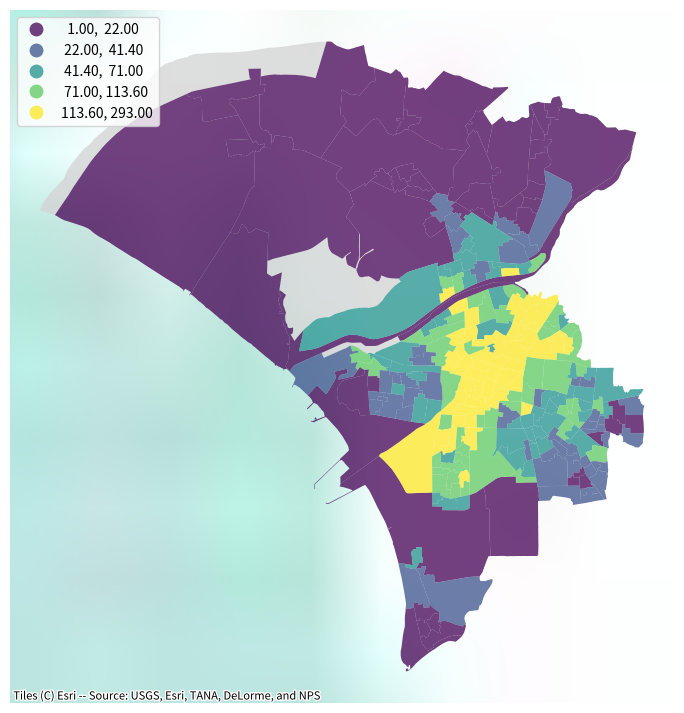

In [373]:
f, ax = plt.subplots(1, figsize=(9, 9))

# ✅ 先繪製 count 為 0 的區塊，顏色固定為灰色
db[db["count"] == 0].plot(
    color="lightgray",  # 固定灰色
    edgecolor="white",  # 邊界顏色
    linewidth=0.0,      # 無邊界線
    alpha=0.75,         # 半透明
    ax=ax               # 繪製在同一個 ax 上
)

# ✅ 再繪製 count > 0 的資料，使用分級色帶
db[db["count"] > 0].plot(
    column="count",                # 使用 count 欄位作為分級依據
    cmap="viridis",                # 色帶樣式
    scheme="quantiles",            # 使用分位數分級
    k=5,                           # 分成 5 等級
    edgecolor="white",             # 邊界顏色
    linewidth=0.0,                 # 無邊界線
    alpha=0.75,                    # 半透明
    legend=True,                   # 顯示圖例
    legend_kwds={"loc": 2},        # 圖例位置：左上角
    ax=ax                          # 繪製在同一個 ax 上
)


# ✅ 加入底圖（需要已投影為 Web Mercator）
contextily.add_basemap(
    ax,
    crs=db.crs,  # 使用原始資料的座標系統
    source=contextily.providers.Esri.WorldTerrain,  # 底圖來源
    zoom=6       # 底圖縮放層級
)

# ✅ 移除軸線
ax.set_axis_off()

In [374]:
# # ✅ 繪圖
# fig, ax = plt.subplots(figsize=(10, 10))
# db.plot(
#     column="count",
#     cmap="OrRd",
#     legend=True,
#     linewidth=0.1,
#     edgecolor="gray",
#     ax=ax
# )
# ax.set_xlim(db.total_bounds[0], db.total_bounds[2])
# ax.set_ylim(db.total_bounds[1], db.total_bounds[3])
# contextily.add_basemap(ax, crs=db.crs, zoom=12)
# ax.set_axis_off()
# ax.set_title("臺南最小統計區病例分布（count）", fontsize=16)
# plt.tight_layout()
# plt.show()

# Global spatial autocorrelation

In [375]:
# @title 使用8個最近鄰居

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8) # 使用8個最近鄰居
# Row-standardization
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」

## Spatial lag

In [376]:
db["count_lag"] = weights.spatial_lag.lag_spatial(
    w, db["count"]
)

In [377]:
db.loc[["A6737-15", "A6733-40"], ["count", "count_lag"]]

,count,count_lag
CODE2,,
A6737-15,293.0,170.250
A6733-40,20.0,24.125


In [378]:
#         # ("R - Row-standardized(行標準化)", "R"),
#         # ("B - Binary(0/1)", "B"),
#         # ("D - Inverse Distance(距離倒數)", "D"),
#         # ("U - Row-sum Unstandardized(原始加總)", "U"),
#         # ("V - Variance-stabilizing", "V"),
#         # ("O - Original(不處理)", "O")

# w = weights.KNN.from_dataframe(db, k=3) # 使用8個最近鄰居

# w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」

# db["count_lag"] = weights.spatial_lag.lag_spatial(
#     w, db["count"]
# )

# db.loc[["A6737-15", "A6733-40"], ["count", "count_lag"]]

In [379]:
# from shapely.geometry import Point
# from shapely.ops import transform
# from math import sqrt

# # 若為 EPSG:3826 (TWD97)，距離單位就是公尺
# def euclidean_distance(pt1, pt2):
#     x1, y1 = pt1.x, pt1.y
#     x2, y2 = pt2.x, pt2.y
#     return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# # 指定要看的區域
# for area_code in ["A6737-15", "A6733-40"]:
#     print(f"Area: {area_code}")

#     neighbors = w.neighbors[area_code]
#     weights_for_area = w.weights[area_code]

#     area_geom = db.loc[area_code].geometry.centroid
#     print(f"  Number of neighbors: {len(neighbors)}")
#     print("  Neighbors and their properties:")

#     for i, neighbor_code in enumerate(neighbors):
#         neighbor_geom = db.loc[neighbor_code].geometry.centroid
#         neighbor_count_value = db.loc[neighbor_code, "count"]
#         weight = weights_for_area[i]
#         dist = euclidean_distance(area_geom, neighbor_geom)
#         weighted_value = neighbor_count_value * weight

#         print(f"    Neighbor: {neighbor_code}, Count: {neighbor_count_value}, Distance: {dist:.2f}m, Weight: {weight:.4f}, Weighted Count: {weighted_value:.4f}")

#     spatial_lag_value = db.loc[area_code, "count_lag"]
#     print(f"  Spatial Lag (W*count) for {area_code}: {spatial_lag_value:.4f}")
#     print("-" * 40)


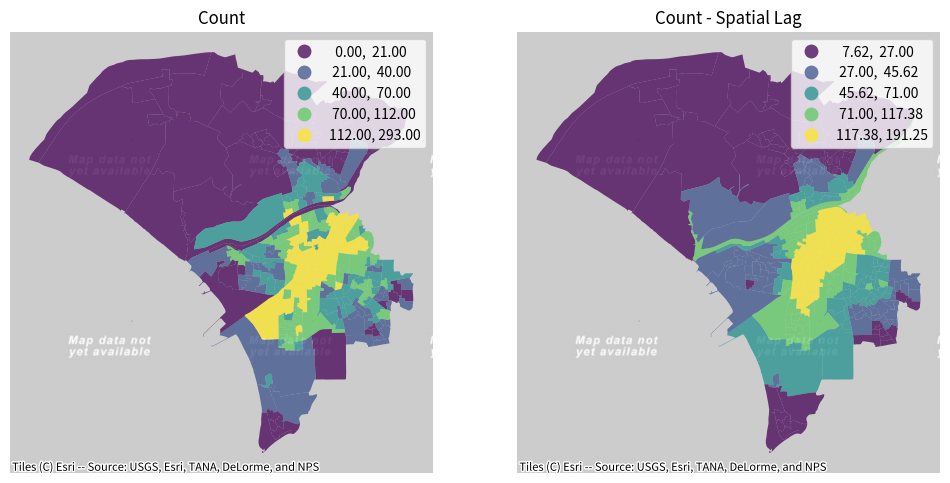

In [380]:
#@title draw spatial lag

f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Count")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="count_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Count - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

## Binary case: join counts

In [381]:
db["count_binary"] = (db["count"] > 60).astype(int)
db[["count", "count_binary"]].tail()

,count,count_binary
CODE2,,
A6736-17,29.0,0
A6736-18,36.0,0
A6736-19,29.0,0
A6736-20,49.0,0
A6736-21,60.0,0


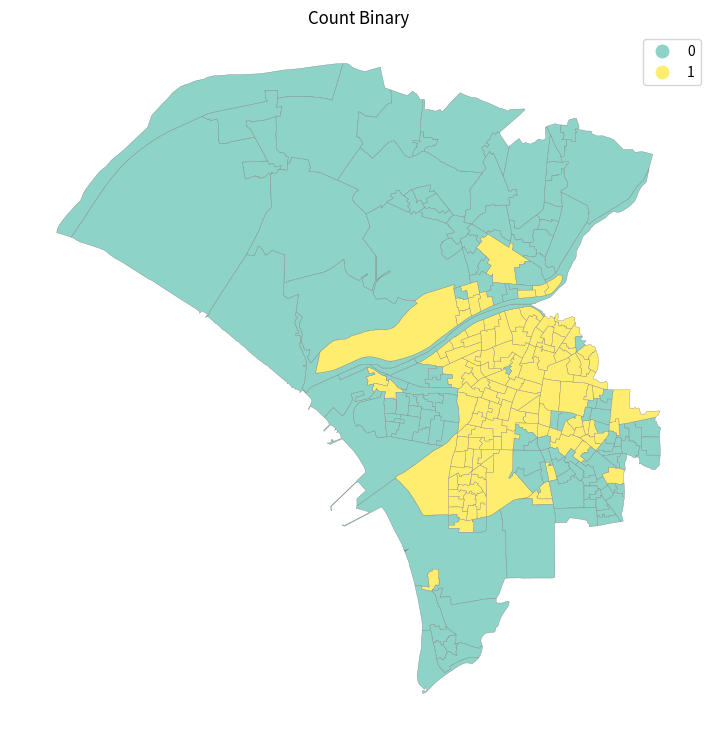

In [382]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="count_binary",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Count Binary")
plt.axis("equal")
plt.show()

In [383]:
w.transform

'R'

In [384]:
w.transform = "O" # 這是設定 PySAL 的空間權重矩陣 w 的權重轉換方式為 "O"，也就是：✅ 不做任何標準化處理，保留原始的權重值。

In [385]:
w.transform

'O'

In [386]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["count_binary"], w)

In [387]:
jc.bb # GG

np.float64(382.5)

In [388]:
jc.ww # YY

np.float64(441.5)

In [389]:
jc.bw # GY

np.float64(220.0)

In [390]:
jc.bb + jc.ww + jc.bw

np.float64(1044.0)

In [391]:
jc.mean_bb # GG

np.float64(230.82732732732734)

In [392]:
jc.mean_bw # GY

np.float64(522.1171171171171)

In [393]:
jc.p_sim_bb

np.float64(0.001)

In [394]:
jc.p_sim_bw

np.float64(1.0)

# Continuous case: Moran Plot and Moran’s I

In [415]:
db["count_std"] = db["count"] - db["count"].mean() # 標準差
db["count_lag_std"] = weights.lag_spatial(
    w, db["count_std"]
)

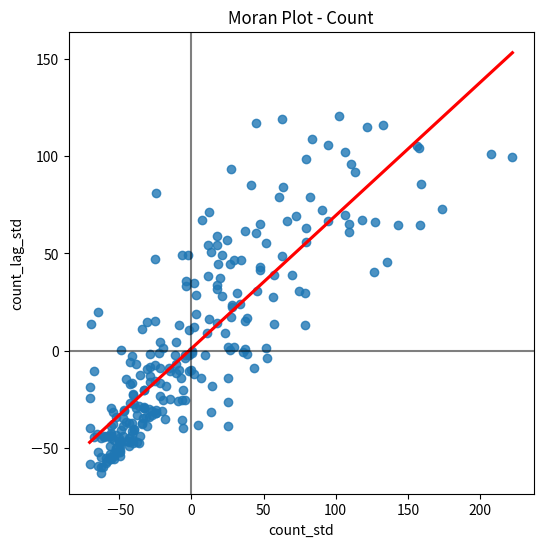

In [416]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="count_std",
    y="count_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Count")
plt.show()

In [425]:
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」
moran = esda.moran.Moran(db["count"], w)

In [426]:
moran.I

np.float64(0.6848281753676654)

In [400]:
moran.p_sim # ✅ 結果具有統計顯著性（空間自相關成立）

np.float64(0.001)

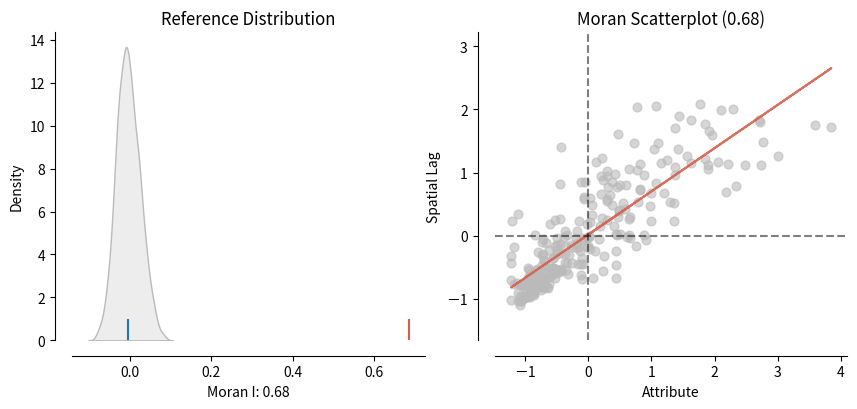

In [401]:
plot_moran(moran);

# Other global indices

## Geary’s C

In [402]:
geary = esda.geary.Geary(db["count"], w)

In [403]:
geary.C # 正向空間自相關（鄰近值相似）

np.float64(0.304658271797323)

In [404]:
geary.p_sim

np.float64(0.001)

## Getis and Ord’s G

In [405]:
# 某個地點周圍是否形成高值或低值的集群。
db_osgb = db.to_crs(epsg=3826) # epsg=3826 TWD97 / epsg=27700 British National Grid
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr # 找出「使得每個點至少有一個鄰居」所需的最小距離 d」

np.float64(2763.068609345829)

In [406]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

In [407]:
gao = esda.getisord.G(db["count"], w_db)

In [408]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.395 | Pseudo P-value: 0.001
